In [2]:
!pip install autorom[accept-rom-license]
!pip install gym[atari]
!pip install gym 

# Space Invaders hiện cả quá trình chơi 

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import cv2

device = "cpu"
print(f"Using device: {device}")

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

class SpaceInvadersAgent:
    def __init__(self, state_shape, n_actions):
        self.device = device
        self.state_shape = state_shape
        self.n_actions = n_actions
        
        self.policy_net = DQN(state_shape, n_actions).to(self.device)
        self.target_net = DQN(state_shape, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.00025)
        self.memory = deque(maxlen=10000) # ghi nhớ 10000 trạng thái gần nhất
        
        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.995
        self.target_update = 1000
        self.steps = 0
        
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.argmax().item()
    
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        state_batch = torch.FloatTensor([s[0] for s in batch]).to(self.device)
        action_batch = torch.LongTensor([s[1] for s in batch]).to(self.device)
        reward_batch = torch.FloatTensor([s[2] for s in batch]).to(self.device)
        next_state_batch = torch.FloatTensor([s[3] for s in batch]).to(self.device)
        done_batch = torch.FloatTensor([s[4] for s in batch]).to(self.device)
        
        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
        
        target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
        
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

def preprocess_frame(frame):
    try:
        # Chuyển frame về grayscale
        if len(frame.shape) == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        # Resize frame về kích thước 84x84
        frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
        
        # Normalize
        frame = frame / 255.0
        return frame
    except Exception as e:
        print(f"Error in preprocessing frame: {e}")
        return np.zeros((84, 84))

def train(episodes=1000):
    try:
        # Tạo môi trường với các tham số phù hợp
        env = gym.make('SpaceInvaders-v0', render_mode='human')
        state_shape = (4, 84, 84)  # Stack 4 frames
        n_actions = env.action_space.n
        
        agent = SpaceInvadersAgent(state_shape, n_actions)
        frame_stack = deque(maxlen=4)
        
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]  # Lấy frame từ tuple trả về
            
            # Khởi tạo frame stack
            for _ in range(4):
                processed_frame = preprocess_frame(state)
                frame_stack.append(processed_frame)
            
            total_reward = 0
            done = False
            truncated = False
            
            while not (done or truncated):
                current_state = np.array(frame_stack)
                action = agent.act(current_state)
                
                # Xử lý kết quả trả về từ env.step
                step_result = env.step(action)
                if len(step_result) == 4:
                    next_state, reward, done, _ = step_result
                else:
                    next_state, reward, terminated, truncated, _ = step_result
                    done = terminated or truncated
                
                processed_next_frame = preprocess_frame(next_state)
                frame_stack.append(processed_next_frame)
                next_state_stack = np.array(frame_stack)
                
                agent.remember(current_state, action, reward, next_state_stack, done)
                agent.replay()
                
                total_reward += reward
            
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {agent.epsilon:.2f}")
        
        env.close()
        
    except Exception as e:
        print(f"Error during training: {e}")
        if 'env' in locals():
            env.close()

if __name__ == "__main__":
    try:
        train()
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"Unexpected error: {e}")

# Space Invaders chỉ hiện score và epsilon

Using device: cpu


c:\ProgramData\anaconda3\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


Starting training...


c:\ProgramData\anaconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
C:\Users\Administrator\AppData\Local\Temp\ipykernel_15008\2710128753.py:82: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  state_batch = torch.FloatTensor([s[0] for s in batch]).to(self.device)


Episode 1: Total Reward: 225.0, Epsilon: 0.930
Episode 2: Total Reward: 125.0, Epsilon: 0.842
Episode 3: Total Reward: 340.0, Epsilon: 0.726
Episode 4: Total Reward: 215.0, Epsilon: 0.652
Episode 5: Total Reward: 15.0, Epsilon: 0.615
Episode 6: Total Reward: 115.0, Epsilon: 0.574
Episode 7: Total Reward: 140.0, Epsilon: 0.522
Episode 8: Total Reward: 115.0, Epsilon: 0.481
Episode 9: Total Reward: 225.0, Epsilon: 0.434
Episode 10: Total Reward: 30.0, Epsilon: 0.402
Episode 11: Total Reward: 130.0, Epsilon: 0.369
Episode 12: Total Reward: 110.0, Epsilon: 0.340
Episode 13: Total Reward: 370.0, Epsilon: 0.309
Episode 14: Total Reward: 20.0, Epsilon: 0.294
Episode 15: Total Reward: 200.0, Epsilon: 0.265
Episode 16: Total Reward: 80.0, Epsilon: 0.249
Episode 17: Total Reward: 55.0, Epsilon: 0.233
Episode 18: Total Reward: 75.0, Epsilon: 0.215
Episode 19: Total Reward: 125.0, Epsilon: 0.195
Episode 20: Total Reward: 60.0, Epsilon: 0.186
Model saved to model_episode_20.h5
Episode 21: Total Rew

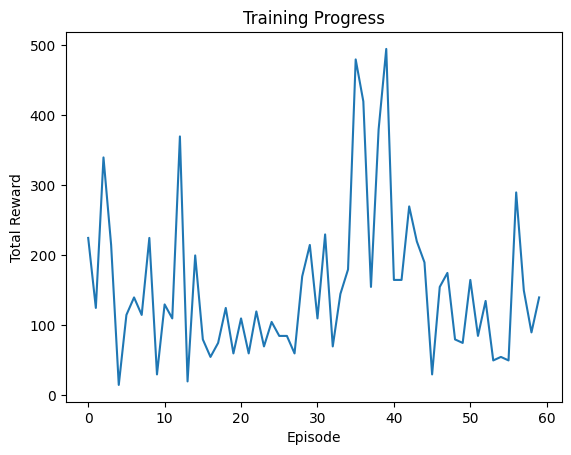

Training completed!


In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import cv2
import matplotlib.pyplot as plt  # Thêm Matplotlib để vẽ biểu đồ

# su
device = "cpu"
print(f"Using device: {device}")

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        """

        Khởi tạo mạng Deep Q Learning với input_shape ,
        ta có input là 4 frame 84x84 , vì mỗi trạng thái mà agent quan sát 
        thường không chỉ là một ảnh (frame) đơn lẻ, mà là chuỗi nhiều khung hình (ở đây là 4 khung) được lấy liên tiếp 
        và ghép lại với nhau để đảm bảo nó học được động thái và chuyển động của agent trong game
        
        """
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4), # Số lượng filter (32 filter) với kích thước 8x8 và stride bằng 4 để di chuyển filter 4 pixel mỗi lần
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2), # thêm 64 filter với kích thước 4x4 và stride bằng 2
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape) # Giá trị này sẽ xác định kích thước đầu vào cho lớp fully connected (self.fc)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        """
        torch.zeros(1, *shape): Tạo một tensor ảo với kích thước 1 x input_shape[0] x 84 x 84 (đầu vào là 4 kênh, 
        mỗi kênh là ảnh 84x84).
        self.conv(o): Đưa tensor ảo qua khối tích chập self.conv. Kết quả sẽ là một tensor đã qua các lớp tích chập 
        và giảm kích thước theo các cấu hình kernel và stride.
        np.prod(o.size()): Tính tổng số phần tử trong tensor đầu ra o bằng cách lấy tích của tất cả các chiều của nó. 
        Đây chính là conv_out_size — giá trị đầu ra của toàn bộ khối tích chập khi được "phẳng hóa" (flatten) 
        thành một vector.
        """

        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    
    def forward(self, x):
        """
        hàm forward sẽ thực hiện quá trình feedforward của mạng,
        - self.conv(x): Ảnh đầu vào đi qua các lớp tích chập.
        - .view(x.size()[0], -1): Chuyển đổi tensor đầu ra từ khối tích chập thành dạng vector để đưa vào khối fc.
        - self.fc(conv_out): Vector sau khi flatten đi qua các lớp fully connected để tạo ra đầu ra cuối cùng.
        """
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

class SpaceInvadersAgent:
    def __init__(self, state_shape, n_actions):
        self.device = device # xác định thiết bị chạy mô hình
        self.state_shape = state_shape # kích thước trạng thái 
        self.n_actions = n_actions # số lượng hành động
        
        self.policy_net = DQN(state_shape, n_actions).to(self.device) # Dùng để dự đoán Q-values cho các hành động.
        self.target_net = DQN(state_shape, n_actions).to(self.device) # Dùng để tính target Q-values.
        self.target_net.load_state_dict(self.policy_net.state_dict())
        
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.00025)
        self.memory = deque(maxlen=50000)  # kích thước memory để nhớ được 50000 trạng thái gần nhất
        
        self.batch_size = 64  # batch size 64 
        self.gamma = 0.99 # gamma để giảm giá trị của các action xa
        self.epsilon = 1.0 # Tăng epsilon để khám phá
        self.epsilon_min = 0.1 # Điều chỉnh epsilon min để không giảm quá nhanh
        self.epsilon_decay = 0.9995  # Điều chỉnh epsilon decay để giảm epsilon sau mỗi bước
        self.target_update = 1000 # Cập nhật mô hình target sau 1000 bước
        self.steps = 0 # Đếm số bước
        
    def remember(self, state, action, reward, next_state, done):
        """
        - Lưu lại một trải nghiệm gồm (state, action, reward, next_state, done) vào self.memory.
        - Trải nghiệm này sẽ được dùng để huấn luyện mô hình khi replay (tái trải nghiệm).
        """
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        """
        - Chiến lược epsilon-greedy:                                                                                                                        nếu một số ngẫu nhiên nhỏ hơn epsilon, chọn hành động ngẫu nhiên để khám phá. 
        Nếu không, chọn hành động tối ưu (dựa trên Q-values).
        - self.policy_net(state): Tính Q-values của state bằng policy_net. Hành động được chọn là hành động có Q-value 
        cao nhất.
        """
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)

        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.argmax().item()
    
    def replay(self):
        """
        Tạo state_batch, action_batch, reward_batch, next_state_batch, done_batch từ bộ nhớ.
        Q-values hiện tại (current_q_values): Tính Q-values từ policy_net cho state_batch và chọn Q-value tương ứng 
        với action_batch 
        Q-values mục tiêu (target_q_values):
        Lấy Q-value lớn nhất từ target_net cho next_state_batch.
        Tính giá trị mục tiêu: reward_batch + (1 - done_batch) * self.gamma * next_q_values.
        Tính loss: Dùng nn.MSELoss để tính mất mát giữa current_q_values và target_q_values.
        Cập nhật policy_net bằng cách tính gradient và tối ưu loss.
        Giảm dần epsilon để giảm tỷ lệ khám phá.
        Cập nhật target_net mỗi self.target_update bước để nó khớp với policy_net.
        """
        if len(self.memory) < self.batch_size:
            return
        
        batch = random.sample(self.memory, self.batch_size)
        state_batch = torch.FloatTensor([s[0] for s in batch]).to(self.device)
        action_batch = torch.LongTensor([s[1] for s in batch]).to(self.device)
        reward_batch = torch.FloatTensor([s[2] for s in batch]).to(self.device)
        next_state_batch = torch.FloatTensor([s[3] for s in batch]).to(self.device)
        done_batch = torch.FloatTensor([s[4] for s in batch]).to(self.device)
        
        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
        
        target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values # công thức update q-value
        
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

def preprocess_frame(frame):
    try:
        # Chuyển frame về grayscale
        if len(frame.shape) == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        # Resize frame về kích thước nhỏ hơn để tăng tốc độ xử lý
        frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
        
        # Normalize
        frame = frame / 255.0
        return frame
    except Exception as e:
        print(f"Error in preprocessing frame: {e}")
        return np.zeros((84, 84))

def train(episodes=60):
    try:
        # Tạo môi trường không có render
        env = gym.make('SpaceInvaders-v0', render_mode=None)
        state_shape = (4, 84, 84)
        n_actions = env.action_space.n
        
        agent = SpaceInvadersAgent(state_shape, n_actions)
        frame_stack = deque(maxlen=4)
        
        # Thêm biến để theo dõi hiệu suất
        episode_rewards = []
        best_reward = float('-inf')
        frame_skip = 4  # Số frame bỏ qua để tăng tốc
        
        print("Starting training...")
        for episode in range(episodes):
            state = env.reset()
            if isinstance(state, tuple):
                state = state[0]
            
            # Khởi tạo frame stack
            for _ in range(4):
                processed_frame = preprocess_frame(state)
                frame_stack.append(processed_frame)
            
            total_reward = 0
            done = False
            
            while not done:
                current_state = np.array(frame_stack)
                action = agent.act(current_state)
                
                # Frame skipping - lặp lại hành động nhiều lần
                # Frame skipping là kỹ thuật trong học tăng cường giúp giảm tải tính toán bằng cách lặp lại một hành động trong nhiều khung hình, 
                # Thực hiện một hành động mới cho từng khung hình. Điều này giảm số lần tính toán mà vẫn giữ nguyên hành vi của agent.
                skip_reward = 0
                for _ in range(frame_skip):
                    step_result = env.step(action)
                    if len(step_result) == 4:
                        next_state, reward, done, _ = step_result
                    else:
                        next_state, reward, terminated, truncated, _ = step_result
                        done = terminated or truncated
                        
                    skip_reward += reward
                    if done:
                        break
                
                processed_next_frame = preprocess_frame(next_state)
                frame_stack.append(processed_next_frame)
                next_state_stack = np.array(frame_stack)
                
                agent.remember(current_state, action, skip_reward, next_state_stack, done)
                agent.replay()
                
                total_reward += skip_reward
            
            episode_rewards.append(total_reward)  # Lưu lại reward của mỗi episode
            
            # In chỉ số điểm số và epsilon
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

            # Lưu mô hình mỗi 20 episode
            if (episode + 1) % 20 == 0:
                model_filename = f'model_episode_{episode + 1}.h5'
                torch.save(agent.policy_net.state_dict(), model_filename)
                print(f"Model saved to {model_filename}")
        
        env.close()
        
        # Vẽ biểu đồ sau khi training hoàn thành
        plt.plot(episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Training Progress')
        plt.show()
        
        print("Training completed!")
        
    except Exception as e:
        print(f"Error during training: {e}")
        if 'env' in locals():
            env.close()

if __name__ == "__main__":
    try:
        train()
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"Unexpected error: {e}")


In [1]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import cv2
import pygame
import matplotlib.pyplot as plt
from gym import spaces

device = "cpu"

# DQN network class giữ nguyên
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

# Agent giữ nguyên
class SpaceInvadersAgent:
    def __init__(self, state_shape, n_actions):
        self.device = device
        self.state_shape = state_shape
        self.n_actions = n_actions
        self.policy_net = DQN(state_shape, n_actions).to(self.device)
        self.target_net = DQN(state_shape, n_actions).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=0.00025)
        self.memory = deque(maxlen=50000)
        self.batch_size = 64
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.9995
        self.target_update = 1000
        self.steps = 0

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if random.random() < self.epsilon:
            return random.randrange(self.n_actions)
        with torch.no_grad():
            state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
            q_values = self.policy_net(state)
            return q_values.argmax().item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        state_batch = torch.FloatTensor([s[0] for s in batch]).to(self.device)
        action_batch = torch.LongTensor([s[1] for s in batch]).to(self.device)
        reward_batch = torch.FloatTensor([s[2] for s in batch]).to(self.device)
        next_state_batch = torch.FloatTensor([s[3] for s in batch]).to(self.device)
        done_batch = torch.FloatTensor([s[4] for s in batch]).to(self.device)
        current_q_values = self.policy_net(state_batch).gather(1, action_batch.unsqueeze(1))
        with torch.no_grad():
            next_q_values = self.target_net(next_state_batch).max(1)[0]
        target_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
        loss = nn.MSELoss()(current_q_values.squeeze(), target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        self.steps += 1
        if self.steps % self.target_update == 0:
            self.target_net.load_state_dict(self.policy_net.state_dict())

# Custom environment với 2 cây súng và background tùy chỉnh
class CustomSpaceInvaders(gym.Env):
    def __init__(self):
        super(CustomSpaceInvaders, self).__init__()
        pygame.init()
        self.width = 800
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption('Custom Space Invaders')
        self.clock = pygame.time.Clock()
        self.player_width = 60
        self.player_height = 40
        self.player_x = self.width // 2 - self.player_width // 2
        self.player_y = self.height - self.player_height - 10
        self.gun_positions = [(self.player_x + 10, self.player_y), (self.player_x + self.player_width - 20, self.player_y)]
        self.bullets = []
        self.bullet_speed = 7
        self.enemies = []
        self.enemy_speed = 2
        self.spawn_enemies()
        self.bg_color = (20, 20, 50)
        self.stars = self.create_stars(100)
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
        self.score = 0
        self.game_over = False

    def spawn_enemies(self):
        for i in range(5):
            x = random.randint(0, self.width - 40)
            y = random.randint(0, 100)
            self.enemies.append(pygame.Rect(x, y, 40, 40))

    def create_stars(self, count):
        return [(random.randint(0, self.width), random.randint(0, self.height)) for _ in range(count)]

    def reset(self):
        self.player_x = self.width // 2 - self.player_width // 2
        self.bullets.clear()
        self.enemies.clear()
        self.spawn_enemies()
        self.game_over = False
        self.score = 0
        frame = pygame.surfarray.array3d(self.screen)
        return preprocess_frame(frame)

    def step(self, action):
        if action == 0:  # Move left
            self.player_x = max(self.player_x - 5, 0)
        elif action == 1:  # Move right
            self.player_x = min(self.player_x + 5, self.width - self.player_width)
        elif action == 2:  # Shoot
            for pos in self.gun_positions:
                self.bullets.append(pygame.Rect(pos[0], pos[1], 5, 10))
        
        # Update bullets and enemies
        reward = 0
        for bullet in self.bullets[:]:
            bullet.y -= self.bullet_speed
            if bullet.y < 0:
                self.bullets.remove(bullet)
            for enemy in self.enemies[:]:
                if bullet.colliderect(enemy):
                    self.bullets.remove(bullet)
                    self.enemies.remove(enemy)
                    reward += 1
                    break

        for enemy in self.enemies:
            enemy.y += self.enemy_speed
            if enemy.y > self.height:
                self.game_over = True
        
        if not self.enemies:
            self.spawn_enemies()
        
        done = self.game_over
        frame = pygame.surfarray.array3d(self.screen)
        state = preprocess_frame(frame)
        return state, reward, done, {}

    def render(self, mode='human'):
        self.screen.fill(self.bg_color)
        for star in self.stars:
            pygame.draw.circle(self.screen, (255, 255, 255), star, 2)
        pygame.draw.rect(self.screen, (0, 255, 0), (self.player_x, self.player_y, self.player_width, self.player_height))
        for bullet in self.bullets:
            pygame.draw.rect(self.screen, (255, 0, 0), bullet)
        for enemy in self.enemies:
            pygame.draw.rect(self.screen, (255, 255, 0), enemy)
        pygame.display.flip()
        self.clock.tick(30)

    def close(self):
        pygame.quit()
      
def preprocess_frame(frame):
    try:
        if len(frame.shape) == 3:
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
        frame = frame / 255.0
        return frame
    except Exception as e:
        print(f"Error in preprocessing frame: {e}")
        return np.zeros((84, 84))

def train(episodes=10):
    try:
        # Sử dụng môi trường tùy chỉnh thay vì môi trường gym gốc
        env = CustomSpaceInvaders()
        state_shape = (4, 84, 84)
        n_actions = env.action_space.n
        
        # Sử dụng agent gốc với môi trường mới
        agent = SpaceInvadersAgent(state_shape, n_actions)
        frame_stack = deque(maxlen=4)
        
        episode_rewards = []
        best_reward = float('-inf')
        frame_skip = 4
        
        print("Starting training...")
        for episode in range(episodes):
            state = env.reset()
            
            # Khởi tạo frame stack
            for _ in range(4):
                processed_frame = preprocess_frame(state)
                frame_stack.append(processed_frame)
            
            total_reward = 0
            done = False
            
            while not done:
                # Hiển thị trò chơi trực tiếp
                env.render()
                
                current_state = np.array(frame_stack)
                action = agent.act(current_state)
                
                # Frame skipping
                skip_reward = 0
                for _ in range(frame_skip):
                    next_state, reward, done, _ = env.step(action)
                    skip_reward += reward
                    if done:
                        break
                
                processed_next_frame = preprocess_frame(next_state)
                frame_stack.append(processed_next_frame)
                next_state_stack = np.array(frame_stack)
                
                agent.remember(current_state, action, skip_reward, next_state_stack, done)
                agent.replay()
                
                total_reward += skip_reward
            
            episode_rewards.append(total_reward)
            print(f"Episode {episode + 1}: Total Reward: {total_reward}, Epsilon: {agent.epsilon:.3f}")

            if (episode + 1) % 5 == 0:
                model_filename = f'model_episode_{episode + 1}.h5'
                torch.save(agent.policy_net.state_dict(), model_filename)
                print(f"Model saved to {model_filename}")
        
        env.close()
        
        plt.plot(episode_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.title('Training Progress')
        plt.show()
        
        print("Training completed!")
        
    except Exception as e:
        print(f"Error during training: {e}")
        if 'env' in locals():
            env.close()

if __name__ == "__main__":
    try:
        train()
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
    except Exception as e:
        print(f"Unexpected error: {e}")


Starting training...


C:\Users\Administrator\AppData\Local\Temp\ipykernel_1140\1178655004.py:78: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  state_batch = torch.FloatTensor([s[0] for s in batch]).to(self.device)


Episode 1: Total Reward: 1, Epsilon: 0.998
Episode 2: Total Reward: 1, Epsilon: 0.966


: 

In [ ]:
import gym
import numpy as np
import torch
import torch.nn as nn
import pygame
import random
import cv2
from gym import spaces
from collections import deque

# Định nghĩa DQN
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

# Môi trường Space Invaders tùy chỉnh
class CustomSpaceInvaders(gym.Env):
    def __init__(self):
        super(CustomSpaceInvaders, self).__init__()
        pygame.init()
        self.width = 800
        self.height = 600
        self.screen = pygame.display.set_mode((self.width, self.height))
        pygame.display.set_caption('Custom Space Invaders')
        
        # Các thuộc tính game
        self.player_width = 60
        self.player_height = 40
        self.player_x = self.width // 2 - self.player_width // 2
        self.player_y = self.height - self.player_height - 10
        
        # Vị trí hai súng
        self.gun_width = 10
        self.gun_height = 20
        self.left_gun_x = self.player_x + 10
        self.right_gun_x = self.player_x + self.player_width - 20
        
        # Đạn
        self.bullets = []
        self.bullet_width = 5
        self.bullet_height = 10
        self.bullet_speed = 7
        
        # Kẻ thù
        self.enemies = []
        self.enemy_width = 40
        self.enemy_height = 40
        self.enemy_speed = 2
        self.spawn_enemies()
        
        # Thay đổi background
        self.bg_color = self.random_background()
        
        # Action và observation spaces
        self.action_space = spaces.Discrete(3)  # Left, Right, Shoot
        self.observation_space = spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)
        
        self.score = 0
        self.game_over = False
    
    def random_background(self):
        # Tạo màu nền ngẫu nhiên
        return (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

    def step(self, action):
        # Xử lý hành động
        if action == 0:  # Move left
            self.player_x -= 5
        elif action == 1:  # Move right
            self.player_x += 5
        elif action == 2:  # Shoot
            self.shoot()
        self.player_x = max(0, min(self.width - self.player_width, self.player_x))
        
        # Cập nhật và vẽ background
        self.screen.fill(self.bg_color)
        
        # Vẽ hai súng
        pygame.draw.rect(self.screen, (255, 0, 0), (self.left_gun_x, self.player_y, self.gun_width, self.gun_height))
        pygame.draw.rect(self.screen, (255, 0, 0), (self.right_gun_x, self.player_y, self.gun_width, self.gun_height))
        
        # Cập nhật kẻ thù và vẽ chúng
        self.update_enemies()
        
        # Vẽ đạn
        for bullet in self.bullets:
            bullet[1] -= self.bullet_speed
            pygame.draw.rect(self.screen, (0, 255, 0), (bullet[0], bullet[1], self.bullet_width, self.bullet_height))
            if bullet[1] < 0:
                self.bullets.remove(bullet)
        pygame.display.flip()
        
        observation = self._get_observation()
        reward = self.score
        done = self.game_over
        
        return observation, reward, done, {}

    def shoot(self):
        left_bullet = [self.left_gun_x + self.gun_width // 2 - self.bullet_width // 2, self.player_y]
        right_bullet = [self.right_gun_x + self.gun_width // 2 - self.bullet_width // 2, self.player_y]
        self.bullets.append(left_bullet)
        self.bullets.append(right_bullet)

    def reset(self):
        self.bg_color = self.random_background()
        self.player_x = self.width // 2 - self.player_width // 2
        self.bullets.clear()
        self.score = 0
        self.game_over = False
        self.spawn_enemies()

        return self._get_observation()

    def _get_observation(self):
        return np.random.randint(0, 255, (84, 84, 1), dtype=np.uint8)

    def update_enemies(self):
        for enemy in self.enemies:
            enemy[1] += self.enemy_speed
            if enemy[1] > self.height:
                self.game_over = True
            pygame.draw.rect(self.screen, (255, 255, 0), (enemy[0], enemy[1], self.enemy_width, self.enemy_height))

    def spawn_enemies(self):
        for _ in range(5):
            x = random.randint(0, self.width - self.enemy_width)
            y = random.randint(-100, 0)
            self.enemies.append([x, y])

# Hàm chơi thử
def test_agent(model_path):
    env = CustomSpaceInvaders()
    state_shape = (4, 84, 84)
    n_actions = env.action_space.n

    # Khởi tạo mô hình
    model = DQN(state_shape, n_actions)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    frame_stack = deque(maxlen=4)
    state = env.reset()
    for _ in range(4):
        processed_frame = preprocess_frame(state)
        frame_stack.append(processed_frame)

    done = False
    total_reward = 0
    while not done:
        current_state = np.array(frame_stack)
        with torch.no_grad():
            q_values = model(torch.FloatTensor(current_state).unsqueeze(0))
            action = q_values.argmax().item()

        next_state, reward, done, _ = env.step(action)
        processed_next_frame = preprocess_frame(next_state)
        frame_stack.append(processed_next_frame)

        total_reward += reward
        state = next_state

    env.close()
    print(f"Total Reward in Test: {total_reward}")

def preprocess_frame(frame):
    if len(frame.shape) == 3 and frame.shape[2] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    frame = frame / 255.0
    return frame

if __name__ == "__main__":
    test_agent("model_episode_10.h5")  # Thay X bằng số episode mà bạn muốn load


Total Reward in Test: 0


: 

In [2]:
import gym
import numpy as np
import torch
import torch.nn as nn
import cv2
from collections import deque

device = "cpu"

# Hàm tiền xử lý frame
def preprocess_frame(fra
                     me):
    if len(frame.shape) == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    frame = frame / 255.0
    return frame

class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

# Hàm để chơi 1 ván game
def play_game(model_path, episodes=1):
    env = gym.make('SpaceInvaders-v0', render_mode="human")  # Chuyển sang v4
    state_shape = (4, 84, 84)
    n_actions = env.action_space.n
    
    # Tạo lại mô hình DQN
    model = DQN(state_shape, n_actions).to(device)
    
    # Tải lại mô hình từ file
    model.load_state_dict(torch.load(model_path))
    model.eval()  # Đặt model ở chế độ đánh giá
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        # Khởi tạo frame stack
        frame_stack = deque(maxlen=4)
        for _ in range(4):
            processed_frame = preprocess_frame(state)
            frame_stack.append(processed_frame)
        
        total_reward = 0
        done = False
        
        while not done:
            current_state = np.array(frame_stack)
            with torch.no_grad():
                state_tensor = torch.FloatTensor(current_state).unsqueeze(0).to(device)
                q_values = model(state_tensor)
                action = q_values.argmax().item()
            
            # Thực hiện hành động
            step_result = env.step(action)

            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            total_reward += reward
            
            # Tiền xử lý frame tiếp theo
            processed_next_frame = preprocess_frame(next_state)
            frame_stack.append(processed_next_frame)
        
        print(f"Episode {episode + 1}: Total Reward: {total_reward}")
    
    env.close()

# Chạy thử một ván với mô hình đã huấn luyện
if __name__ == "__main__":
    model_path = 'model_episode_60.h5'  # Đường dẫn tới file .h5 hoặc .pth của bạn
    play_game(model_path)




c:\ProgramData\anaconda3\Lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment SpaceInvaders-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(


Episode 1: Total Reward: 205.0


Do thời gian train khi sử dụng Agent tự tạo ra tốn thời gian train rất lớn nên ở các mô hình tiếp theo thì ta sẽ sử dụng Agent do gym tạo ra để học và áp dụng vào model 

# Double Q Learning

In [3]:
import gym
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from collections import deque

device = "cpu"

# Định nghĩa DQN tương tự như trước
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        conv_out_size = self._get_conv_out(input_shape)
        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )
    
    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))
    
    def forward(self, x):
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)

# Hàm preprocess_frame 
def preprocess_frame(frame):
    if len(frame.shape) == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    frame = frame / 255.0
    return frame

def double_q_learning(env, episodes = 300, gamma=0.99, epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=0.995):
    state_shape = (4, 84, 84)
    n_actions = env.action_space.n
    
    policy_net = DQN(state_shape, n_actions).to(device)
    target_net = DQN(state_shape, n_actions).to(device)
    optimizer = optim.Adam(policy_net.parameters(), lr=0.00025)

    total_rewards = []
    
    epsilon = epsilon_start  # Khởi tạo epsilon

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        frame_stack = deque(maxlen=4)
        for _ in range(4):
            processed_frame = preprocess_frame(state)
            frame_stack.append(processed_frame)

        total_reward = 0
        done = False
        
        while not done:
            current_state = np.array(frame_stack)
            current_state = np.stack(current_state, axis=0)  # Kích thước sẽ là (4, 84, 84)
            state_tensor = torch.FloatTensor(current_state).unsqueeze(0).to(device)  # Chuyển đổi kích thước
            
            # Chọn hành động theo epsilon-greedy
            if np.random.rand() < epsilon:
                action = np.random.choice(n_actions)  # Khám phá
            else:
                with torch.no_grad():
                    q_values = policy_net(state_tensor)
                action = q_values.argmax().item()  # Tối ưu
            
            # Step trong môi trường
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            processed_next_frame = preprocess_frame(next_state)
            frame_stack.append(processed_next_frame)
            total_reward += reward

        total_rewards.append(total_reward)

        # Giảm epsilon
        if epsilon > epsilon_end:
            epsilon *= epsilon_decay

        print(f"Double Q-Learning: Episode {episode + 1}, Reward: {total_reward}")
    
    return total_rewards

# Bellman Equation

In [2]:
import numpy as np
import cv2

def preprocess_frame(frame):
    """Chuyển frame về grayscale, resize và normalize."""
    if len(frame.shape) == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    frame = cv2.resize(frame, (84, 84), interpolation=cv2.INTER_AREA)
    frame = frame / 255.0
    return frame

def discretize_state(state, observation_space):
    """Rời rạc hóa trạng thái cho phù hợp với Q-table vì bellman equation không hoạt động với trạng thái liên tục."""
    state_bins = np.digitize(state.flatten(), observation_space) - 1  # Chuyển thành chỉ số bins
    return state_bins

def bellman_q_learning(env, episodes=300, bins=10):
    n_actions = env.action_space.n
    
    # Giả định ta phân chia không gian quan sát thành các bins cho mỗi giá trị pixel
    observation_space = np.linspace(0, 1, bins)  # Phân chia giá trị pixel từ 0 đến 1 (sau khi normalize)
    
    # Khởi tạo bảng Q với kích thước dựa trên số lượng bins và số hành động
    q_table = np.zeros((bins, bins, n_actions))  # Giả định 2D trạng thái rời rạc hóa
    
    total_rewards = []
    
    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        
        # Tiền xử lý và rời rạc hóa trạng thái ban đầu
        state = preprocess_frame(state)
        state_bins = discretize_state(state, observation_space)
        
        done = False
        total_reward = 0
        
        while not done:
            action = np.random.choice(n_actions)
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated
            
            total_reward += reward
            
            # Tiền xử lý và rời rạc hóa trạng thái tiếp theo
            next_state = preprocess_frame(next_state)
            next_state_bins = discretize_state(next_state, observation_space)
            
            # Bellman Equation cập nhật Q-values
            best_next_action = np.argmax(q_table[next_state_bins[0], next_state_bins[1]])
            q_table[state_bins[0], state_bins[1], action] += 0.1 * (
                reward + 0.99 * q_table[next_state_bins[0], next_state_bins[1], best_next_action] - q_table[state_bins[0], state_bins[1], action]
            )
            # công thức Bellman Equation để cập nhật Q-values là Q(s, a) = Q(s, a) + α(r + γ * max(Q(s', a')) - Q(s, a))
            
            state_bins = next_state_bins
        
        total_rewards.append(total_reward)
        print(f"Bellman Equation: Episode {episode+1}, Reward: {total_reward}")
    
    return total_rewards


# Morte Carlo

In [4]:
def discretize_state(state, bins):
    """Chuyển đổi không gian liên tục của trạng thái thành không gian rời rạc"""
    # Lưu ý: state có thể là một mảng nhiều chiều, ta cần flatten (dẹp thành 1D)
    state_flattened = state.flatten()  # Chuyển mảng nhiều chiều thành 1 chiều
    state_discretized = np.digitize(state_flattened, bins)  # Rời rạc hóa
    return state_discretized.reshape(state.shape)  # Trả lại dạng ban đầu

def monte_carlo(env, episodes=300, bins=10):
    n_actions = env.action_space.n
    
    # Giả định ta phân chia không gian quan sát thành các bins cho mỗi giá trị pixel
    observation_space = np.linspace(0, 255, bins)  # Phân chia giá trị pixel từ 0 đến 255
    
    # Khởi tạo bảng Q với kích thước dựa trên số lượng bins và số hành động
    q_table = np.zeros((bins, bins, n_actions))
    returns = {}

    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]

        # Rời rạc hóa trạng thái ban đầu
        state = preprocess_frame(state)  # Xử lý frame trước khi rời rạc hóa
        state = discretize_state(state, observation_space)
        
        # Chuyển trạng thái thành tuple để làm khóa từ điển
        state_tuple = tuple(state.flatten()) 

        episode_data = []
        done = False
        total_reward = 0

        while not done:
            action = np.random.choice(n_actions)
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated

            # Xử lý và rời rạc hóa frame tiếp theo
            next_state = preprocess_frame(next_state)
            next_state = discretize_state(next_state, observation_space)
            
            # Chuyển trạng thái tiếp theo thành tuple để lưu vào episode_data
            next_state_tuple = tuple(next_state.flatten())
            
            episode_data.append((state_tuple, action, reward))
            state_tuple = next_state_tuple
            total_reward += reward

        total_rewards.append(total_reward)

        # Cập nhật Q-values sau khi episode kết thúc
        g = 0
        for (state, action, reward) in reversed(episode_data):
            g = reward + 0.99 * g
            if (state, action) not in returns:
                returns[(state, action)] = []
            returns[(state, action)].append(g)
            q_table[state, action] = np.mean(returns[(state, action)])
        # công thức morte carlo để cập nhật Q-values là Q(s, a) = Q(s, a) + α(G - Q(s, a))
        
        print(f"Monte Carlo: Episode {episode+1}, Reward: {total_reward}")

    return total_rewards

Running Double Q-Learning...
Double Q-Learning: Episode 1, Reward: 440.0
Double Q-Learning: Episode 2, Reward: 55.0
Double Q-Learning: Episode 3, Reward: 80.0
Double Q-Learning: Episode 4, Reward: 350.0
Double Q-Learning: Episode 5, Reward: 85.0
Double Q-Learning: Episode 6, Reward: 125.0
Double Q-Learning: Episode 7, Reward: 440.0
Double Q-Learning: Episode 8, Reward: 50.0
Double Q-Learning: Episode 9, Reward: 240.0
Double Q-Learning: Episode 10, Reward: 160.0
Double Q-Learning: Episode 11, Reward: 80.0
Double Q-Learning: Episode 12, Reward: 155.0
Double Q-Learning: Episode 13, Reward: 120.0
Double Q-Learning: Episode 14, Reward: 230.0
Double Q-Learning: Episode 15, Reward: 80.0
Double Q-Learning: Episode 16, Reward: 210.0
Double Q-Learning: Episode 17, Reward: 160.0
Double Q-Learning: Episode 18, Reward: 45.0
Double Q-Learning: Episode 19, Reward: 75.0
Double Q-Learning: Episode 20, Reward: 50.0
Double Q-Learning: Episode 21, Reward: 30.0
Double Q-Learning: Episode 22, Reward: 90.0
D

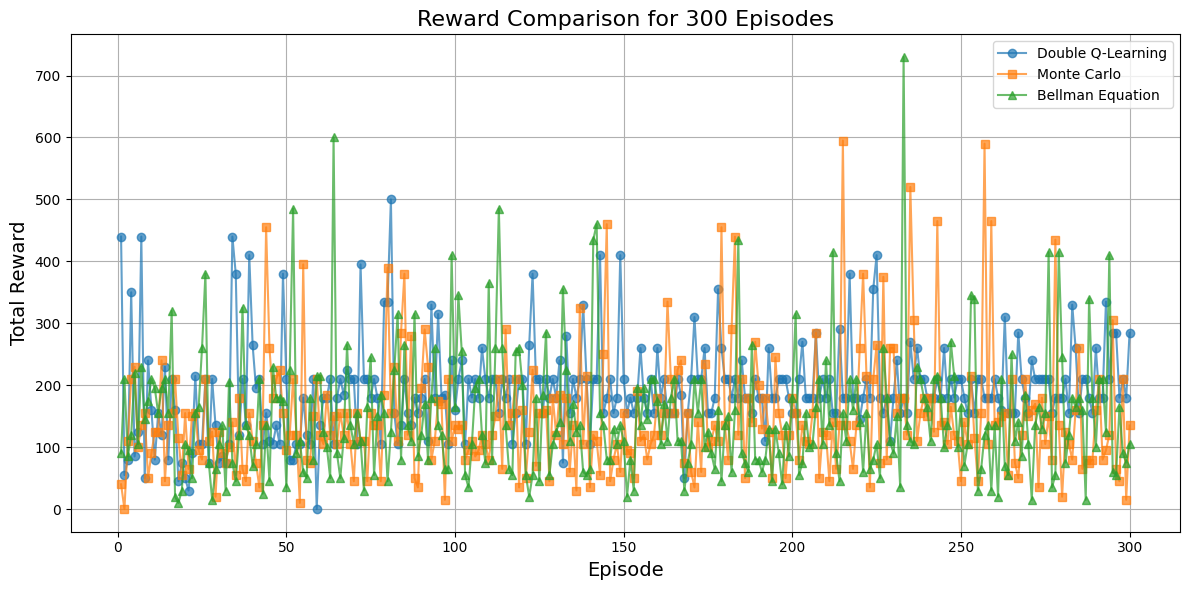

In [9]:
import gym
import matplotlib.pyplot as plt

if __name__ == "__main__":
    # Khởi tạo môi trường Space Invaders
    env = gym.make('SpaceInvaders-v0', render_mode=None)

    # Chạy các thuật toán và lưu lại phần thưởng
    print("Running Double Q-Learning...")
    double_q_rewards = double_q_learning(env)

    print("\nRunning Monte Carlo...")
    monte_carlo_rewards = monte_carlo(env)

    print("\nRunning Bellman Equation...")
    bellman_rewards = bellman_q_learning(env)

    # Đóng môi trường sau khi chạy xong
    env.close()

    # Thiết lập các tập và vẽ biểu đồ
    episodes = range(1, 301)  # Dãy số từ 1 đến 300 để khớp với phần thưởng trong 300 tập
    plt.figure(figsize=(12, 6))
    
    # Vẽ phần thưởng cho từng thuật toán
    plt.plot(episodes, double_q_rewards[:300], label='Double Q-Learning', marker='o', alpha=0.7)
    plt.plot(episodes, monte_carlo_rewards[:300], label='Monte Carlo', marker='s', alpha=0.7)
    plt.plot(episodes, bellman_rewards[:300], label='Bellman Equation', marker='^', alpha=0.7)

    # Cài đặt nhãn trên trục x cách mỗi 50 tập
    plt.xticks(ticks=range(0, 301, 50))

    # Cài đặt tiêu đề và nhãn
    plt.title('Reward Comparison for 300 Episodes', fontsize=16)
    plt.xlabel('Episode', fontsize=14)
    plt.ylabel('Total Reward', fontsize=14)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()



# Temporal Different

TD Q-Learning: Episode 1, Reward: 205.0
TD Q-Learning: Episode 2, Reward: 45.0
TD Q-Learning: Episode 3, Reward: 120.0
TD Q-Learning: Episode 4, Reward: 440.0
TD Q-Learning: Episode 5, Reward: 285.0
TD Q-Learning: Episode 6, Reward: 170.0
TD Q-Learning: Episode 7, Reward: 125.0
TD Q-Learning: Episode 8, Reward: 155.0
TD Q-Learning: Episode 9, Reward: 135.0
TD Q-Learning: Episode 10, Reward: 155.0
TD Q-Learning: Episode 11, Reward: 240.0
TD Q-Learning: Episode 12, Reward: 120.0
TD Q-Learning: Episode 13, Reward: 210.0
TD Q-Learning: Episode 14, Reward: 210.0
TD Q-Learning: Episode 15, Reward: 105.0
TD Q-Learning: Episode 16, Reward: 105.0
TD Q-Learning: Episode 17, Reward: 150.0
TD Q-Learning: Episode 18, Reward: 180.0
TD Q-Learning: Episode 19, Reward: 120.0
TD Q-Learning: Episode 20, Reward: 80.0
TD Q-Learning: Episode 21, Reward: 50.0
TD Q-Learning: Episode 22, Reward: 105.0
TD Q-Learning: Episode 23, Reward: 35.0
TD Q-Learning: Episode 24, Reward: 35.0
TD Q-Learning: Episode 25, Rew

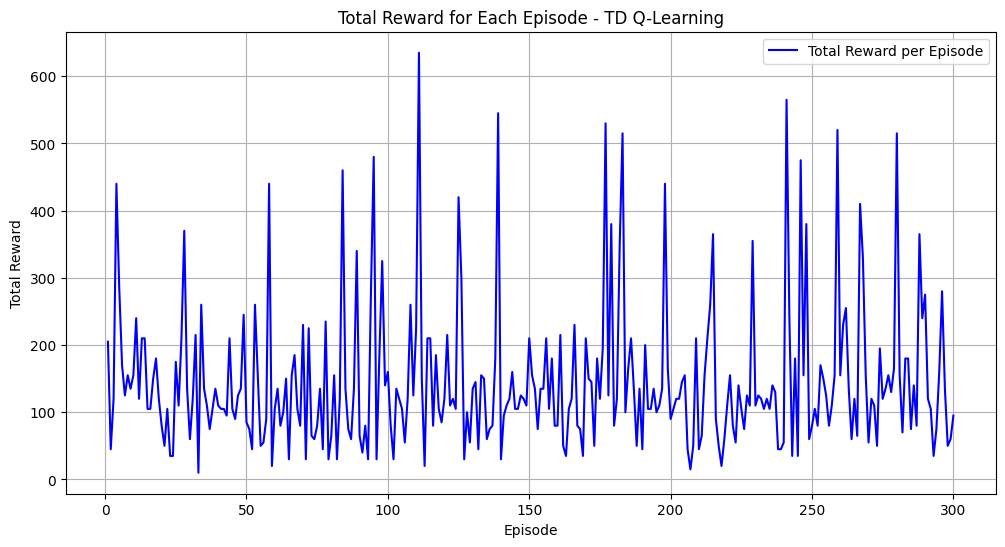

In [11]:

def preprocess_frame(frame):
    """Tiền xử lý ảnh - giảm chiều hoặc lấy phần cần thiết"""
    frame_gray = np.mean(frame, axis=2)  # Chuyển đổi thành ảnh grayscale
    frame_resized = frame_gray[::10, ::10]  # Giảm kích thước bằng cách lấy mẫu
    return frame_resized

def discretize_state(state, bins):
    """Chuyển đổi không gian liên tục của trạng thái thành không gian rời rạc"""
    state_flattened = state.flatten()
    state_discretized = np.digitize(state_flattened, bins)
    return state_discretized.reshape(state.shape)

def td_q_learning(env, episodes=300, bins=10, gamma=0.99, alpha=0.1):
    n_actions = env.action_space.n
    observation_space = np.linspace(0, 255, bins)
    q_table = np.zeros((bins, bins, n_actions))
    total_rewards = []

    for episode in range(episodes):
        state = env.reset()
        if isinstance(state, tuple):
            state = state[0]
        state = preprocess_frame(state)
        state = discretize_state(state, observation_space)
        state_tuple = (state[0, 0], state[-1, -1])  # Rời rạc hóa kích thước về 2 điểm chính để làm chỉ mục

        total_reward = 0
        done = False

        while not done:
            action = np.random.choice(n_actions)
            step_result = env.step(action)
            if len(step_result) == 4:
                next_state, reward, done, _ = step_result
            else:
                next_state, reward, terminated, truncated, _ = step_result
                done = terminated or truncated

            next_state = preprocess_frame(next_state)
            next_state = discretize_state(next_state, observation_space)
            next_state_tuple = (next_state[0, 0], next_state[-1, -1])

            # TD Update cho Q-learning
            best_next_action = np.argmax(q_table[next_state_tuple])
            td_target = reward + gamma * q_table[next_state_tuple][best_next_action]
            td_delta = td_target - q_table[state_tuple][action]
            q_table[state_tuple][action] += alpha * td_delta
            # np.argmax(q_table[next_state_tuple]): Tìm hành động tốt nhất cho trạng thái tiếp theo từ bảng Q. 
            # td_target: Tính toán mục tiêu TD, bao gồm phần thưởng và giá trị Q tối đa cho trạng thái tiếp theo.
            # td_delta: Tính toán sai số giữa mục tiêu TD và giá trị Q hiện tại.
            # Cập nhật bảng Q: Sử dụng công thức cập nhật Q-learning

            total_reward += reward
            state_tuple = next_state_tuple

        total_rewards.append(total_reward)
        print(f"TD Q-Learning: Episode {episode+1}, Reward: {total_reward}")

    return total_rewards

def train_td_q_learning(env, episodes=300):
    rewards = td_q_learning(env, episodes=episodes)
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, episodes + 1), rewards, label="Total Reward per Episode", color='b')
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Total Reward for Each Episode - TD Q-Learning")
    plt.legend()
    plt.grid()
    plt.show()

if __name__ == "__main__":
    env = gym.make('SpaceInvaders-v0', render_mode=None)
    train_td_q_learning(env, episodes=300)
    env.close()
